# Exercice : quadrature de Gauss - Solution


In [1]:
import openturns as ot
import openturns.viewer as otv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def computeDigits(approximate):
    """
    Return the number of correct base 10 digits in the approximate integral.

    Parameters
    ----------
    approximate : float
        The approximate value of the integral.

    Returns
    -------
    d : float
        The log-relative error in base 10.

    """
    data = np.finfo(float)
    exact = 6.586705045354282248777299
    re = abs(approximate - exact) / abs(exact)
    if re == 0.0:
        d = data.precision
    else:
        d = -np.log10(re)
    return d

## Solution

## Définition de la fonction

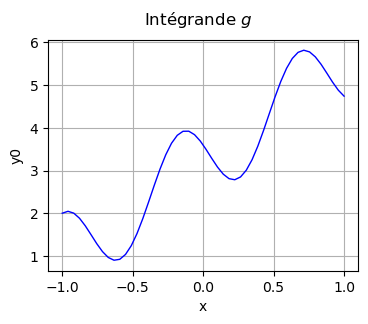

In [3]:
g = ot.SymbolicFunction("x", "1 + cos(15 * (x + 1) / 2) + 9 * (x + 1) / 4")

npoints = 50

graph = g.draw(-1.0, 1.0, npoints)
graph.setTitle("Intégrande $g$")
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

## Avec les polynômes de Legendre

In [4]:
lefa = ot.LegendreFactory()

measure = lefa.getMeasure()
measure

class=Uniform name=Uniform dimension=1 a=-1 b=1

In [5]:
nodes, weights = lefa.getNodesAndWeights(npoints)

len(nodes)

50

In [6]:
nodes[:10]

class=Point name=Unnamed dimension=10 values=[-0.998866,-0.994032,-0.985354,-0.972864,-0.956611,-0.936657,-0.913079,-0.885968,-0.85543,-0.821582]

In [7]:
weights[:10]

class=Point name=Unnamed dimension=10 values=[0.00145431,0.0033799,0.00529527,0.00719041,0.00905778,0.0108901,0.0126803,0.0144215,0.0161069,0.0177299]

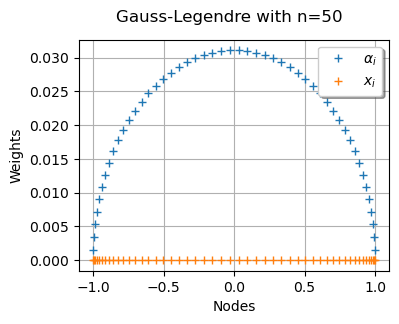

In [8]:
def plotNodesAndWeights(nodes, weights):
    """
    Plot nodes and weights of a quadrature formula.

    Parameters
    ----------
    nodes : ot.Point(n)
        The nodes.
    weights : ot.Point(n)
        The weights.

    Returns
    -------
    graph : ot.Graph
        The weights and the nodes on the Y-axis depending on the
        corresponding abscissa on the X-axis.
    """
    npoints = nodes.getDimension()
    if weights.getDimension() != npoints:
        raise ValueError("The number of nodes and weights must be equal.")
    title = "n=%d" % (npoints)
    graph = ot.Graph(title, "Nodes", "Weights", True)
    cloud = ot.Cloud(nodes, weights)
    cloud.setLegend(r"$\alpha_i$")
    graph.add(cloud)
    zeros = ot.Sample(len(nodes), 1)
    nodes_sample = ot.Sample.BuildFromPoint(nodes)
    cloudZeros = ot.Cloud(nodes_sample, zeros)
    cloudZeros.setLegend(r"$x_i$")
    graph.add(cloudZeros)
    graph.setColors(ot.Drawable().BuildDefaultPalette(2))
    graph.setLegendPosition("topright")
    return graph


graph = plotNodesAndWeights(nodes, weights)
graph.setTitle("Gauss-Legendre with n=%d" % (npoints))
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

On fait les observations suivantes :
- La valeur des poids suit un cercle : la valeur des poids est supérieure au centre du domaine. 
- La densité de points est plus importante sur les bords du domaine. 

L'augmentation de densité des noeuds sur les bords du domaine favorise une limitation de l'amplitude du polynôme nodal :
$$
\omega_{n + 1}(x) = \prod_{i = 0}^n (x - x_i)
$$
pour tout $x \in [-1, 1]$.
En effet, la valeur du polynôme nodale est supérieure sur les bords du domaine, car la valeur de $x$ est plus grande lorsqu'on est proche de $\pm 1$ et plus petite lorsqu'on est proche de zéro. 

- D'une part, l'erreur d'interpolation dépend du nombre de noeuds $n + 1$, de la $(n + 1)$-ème dérivée de la fonction et de la valeur du polynôme nodal au point $x$ ((Dahlquist, Björck, 2008), théorème 4.2.3, "The remainder term for interpolation", page 361). C'est pourquoi l'amplitude du polynôme nodal devrait être la plus petite possible. Si elle est uniforme sur l'intervalle $[-1, 1]$, alors il est plus facile d'assurer une erreur aussi constante que possible. Si au contraire, l'amplitude du polynôme nodal est faible à certains endroits et élevée dans d'autres zone de l'intervalle, alors l'erreur d'interpolation peut être grande. 

- D'autre part, l'erreur de quadrature dépend du nombre de noeuds $n + 1$, de la $(2n + 2)$-ème dérivée de la fonction et de la norme $L^2$ du polynôme nodal ((Sullivan, 2015), page 172, théorème 9.12). Par conséquent, on devrait limiter la norme $L^2$ du polynôme nodal: une amplitude plus petite facilite cet objectif.


**Réferences**
- Dahlquist, G., & Björck, Å. (2008). _"Numerical methods in scientific computing, Volume I"_. Society for Industrial and Applied Mathematics.

- Sullivan, T. J. (2015). Introduction to uncertainty quantification. Springer.


In [9]:
class NodePolynomial(ot.OpenTURNSPythonFunction):
    def __init__(self, nodes):
        """
        Create the node polynomial depending on the nodes

        Parameters
        ----------
        nodes : list(float)
            The list of nodes, in increasing order.
        """
        super(NodePolynomial, self).__init__(1, 1)
        self.nodes = nodes

    def _exec(self, x):
        """
        Evaluates the node polynomial at point x.

        Parameters
        ----------
        x : ot.Point(1)
            The input point.

        Returns
        -------
        y : ot.Point(1)
            The output value.
        """
        value = 1.0
        number_of_nodes = self.nodes.getDimension()
        for i in range(number_of_nodes):
            value *= x[0] - self.nodes[i]
        return [value]

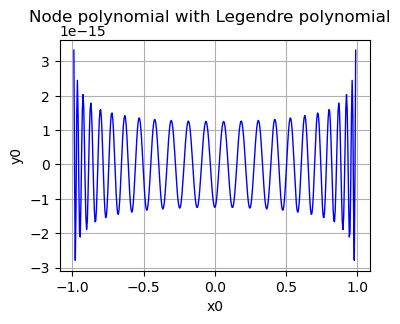

In [10]:
node_polynomial = ot.Function(NodePolynomial(nodes))
epsilon = 1.0e-2
graph = node_polynomial.draw(-1.0 + epsilon, 1.0 - epsilon, 400)
graph.setTitle("Node polynomial with Legendre polynomial")
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

On observe que l'amplitude du polynôme nodal est presque la même sur tout l'intervalle, avec une faible augmentation aux bords. 

Comme la densité de probabilité uniforme est constante sur l'intervalle [-1,1], on peut calculer la valeur une fois pour toute, avant la boucle `for`.

In [11]:
f = measure.computePDF(0.0)
f

0.5

On peut réaliser une boucle `for`, dans laquelle on cumule le produit du poid et de la valeur de la fonction.

In [12]:
I = 0.0
for i in range(npoints):
    I += weights[i] * g([nodes[i]])[0] / f
I

6.586705045354282

Il est plus efficace de vectoriser la somme en l'écrivant sous la forme d'un produit scalaire. Pour cela, on crée la variable `g_values_point` qui est un `Point`. Puisqu'une fonction prend en entrée et en sortie un `Sample`, des conversions sont nécessaires.

In [13]:
def gauss_quadrature(npoints, g_function, orthogonal_factory):
    """
    Perform Gauss quadrature on [-1, 1]

    Parameters
    ----------
    npoints : int
        The number of nodes
    g_function : ot.Function
        The integrand. This has a one dimensional input and output.
    orthogonal_factory : ot.OrthogonalBasis
        The orthogonal basis used for quadrature.

    Returns
    -------
    I : float
        The approximate integral.
    """
    measure = orthogonal_factory.getMeasure()

    def weighted_g_function_Py(x):
        f_PDF = measure.computePDF(x)
        y = g_function(x)[0] / f_PDF
        return [y]

    weighted_g_function = ot.PythonFunction(1, 1, weighted_g_function_Py)
    nodes, weights = orthogonal_factory.getNodesAndWeights(npoints)
    nodes_sample = ot.Sample.BuildFromPoint(nodes)
    g_values = weighted_g_function(nodes_sample)
    g_values_point = g_values.asPoint()
    I = weights.dot(g_values_point)
    return I

In [14]:
I = gauss_quadrature(npoints, g, lefa)
print("I = ", I)
print("Digits = ", computeDigits(I))

I =  6.5867050453542815
Digits =  15.87016799923764


On observe que la précision est maximale avec la règle de Gauss-Legendre.

## Avec les polynômes de Chebyshev

In [15]:
chefa = ot.ChebychevFactory()

measure = chefa.getMeasure()
measure

class=Arcsine name=Arcsine dimension=1 a=-1 b=1

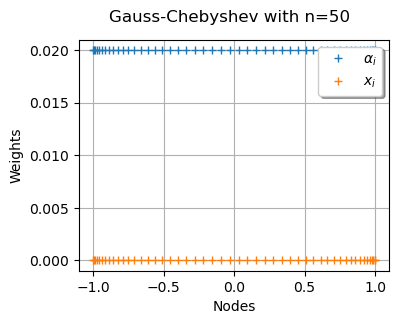

In [16]:
nodes, weights = chefa.getNodesAndWeights(npoints)

graph = plotNodesAndWeights(nodes, weights)
graph.setTitle("Gauss-Chebyshev with n=%d" % (npoints))
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

On observe que la densité des noeuds est supérieure aux bords du domaine. Les poids sont constants sur le domaine. 

In [17]:
I = gauss_quadrature(npoints, g, chefa)
print("I = ", I)
print("Digits = ", computeDigits(I))

I =  6.5878136322623435
Digits =  3.773898470584568


On observe que la précision est moins élevée qu'avec l'intégration par les polynômes de Legendre.

Pour comprendre pourquoi, on commence par dessiner la mesure utilisée pour l'intégration. 

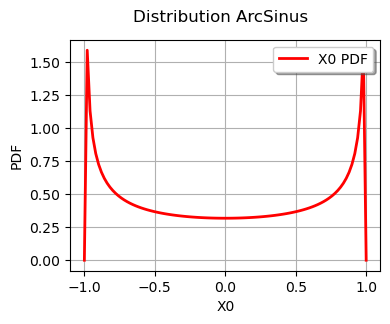

In [18]:
graph = measure.drawPDF(-1.0, 1.0, 100)
graph.setTitle("Distribution ArcSinus")
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

On observe que la densité de probabilité ArcSinus est singulière aux bords du domaine. 
On dessine ensuite la fonction pondérée que nous intégrons. 

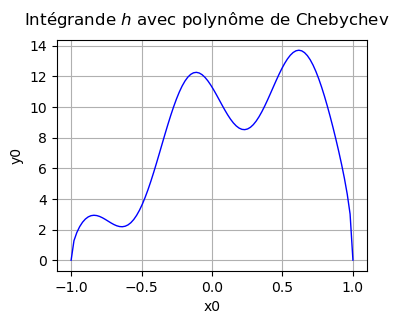

In [19]:
def weighted_g_function_Py(x):
    f_PDF = measure.computePDF(x)
    y = g(x)[0] / f_PDF
    return [y]


weighted_g_function = ot.PythonFunction(1, 1, weighted_g_function_Py)
epsilon = 1.0e-7
graph = weighted_g_function.draw(-1.0 + epsilon, 1.0 - epsilon, 100)
graph.setTitle("Intégrande $h$ avec polynôme de Chebychev")
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

On observe qu'il s'agit d'une fonction relativement régulière. Toutefois, il ne s'agit plus d'une fonction polynomiale, puisque nous avons divisé par la densité de probabilité ArcSinus.

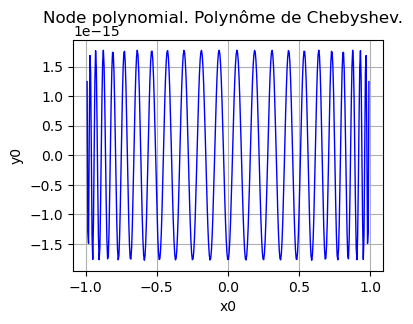

In [20]:
node_polynomial = ot.Function(NodePolynomial(nodes))
epsilon = 1.0e-2
graph = node_polynomial.draw(-1.0 + epsilon, 1.0 - epsilon, 400)
graph.setTitle("Node polynomial. Polynôme de Chebyshev.")
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

On observe que l'amplitude du polynôme nodal est strictement constante sur l'intervalle $[-1,1]$. C'est une propriété caractéristique de ce polynôme, qui diminue son erreur d'interpolation. 

## Avec les polynômes de Jacobi

In [21]:
jafa = ot.JacobiFactory()

measure = jafa.getMeasure()
measure

class=Beta name=Beta dimension=1 alpha=2 beta=2 a=-1 b=1

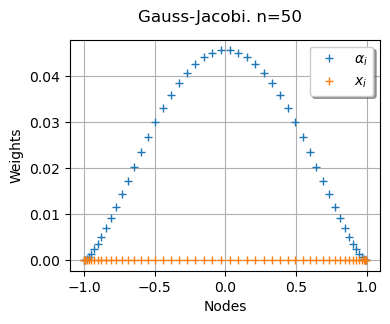

In [22]:
nodes, weights = jafa.getNodesAndWeights(npoints)

graph = plotNodesAndWeights(nodes, weights)
graph.setTitle("Gauss-Jacobi. n=%d" % (npoints))
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

On observe que la densité des noeuds est supérieure aux bords du domaine. Les poids ne sont pas constants sur le domaine : la valeur des poids est supérieure au centre du domaine. 

In [23]:
I = gauss_quadrature(npoints, g, jafa)
print("I = ", I)
print("Digits = ", computeDigits(I))

I =  6.581621853735014
Digits =  3.1125317345825545


On observe que la précision est moins élevée qu'avec l'intégration par les polynômes de Legendre.

Pour comprendre pourquoi, on commence par dessiner la mesure utilisée pour l'intégration. 

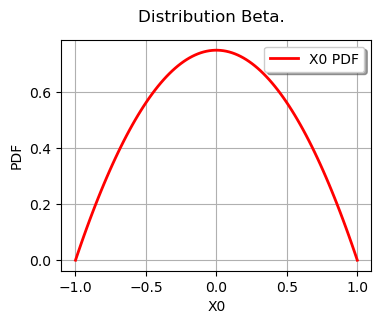

In [24]:
graph = measure.drawPDF(-1.0, 1.0, 100)
graph.setTitle("Distribution Beta.")
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

On observe que la densité de probabilité Beta est nulle aux bords du domaine. 
On dessine ensuite la fonction pondérée que nous intégrons. 

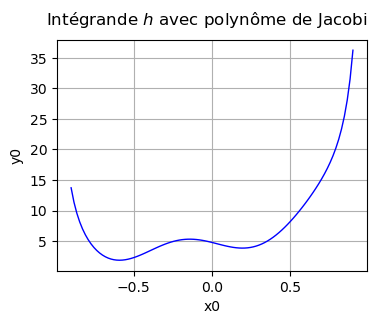

In [25]:
def weighted_g_function_Py(x):
    f_PDF = measure.computePDF(x)
    y = g(x)[0] / f_PDF
    return [y]


weighted_g_function = ot.PythonFunction(1, 1, weighted_g_function_Py)
epsilon = 1.0e-1
graph = weighted_g_function.draw(-1.0 + epsilon, 1.0 - epsilon, 100)
graph.setTitle("Intégrande $h$ avec polynôme de Jacobi")
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

On observe qu'il s'agit d'une fonction relativement régulière au centre du domaine, mais singulière aux bords. Toutefois, il ne s'agit plus d'une fonction polynomiale, puisque nous avons divisé par la densité de probabilité ArcSinus.

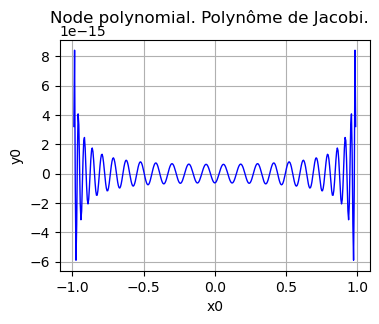

In [26]:
node_polynomial = ot.Function(NodePolynomial(nodes))
epsilon = 1.0e-2
graph = node_polynomial.draw(-1.0 + epsilon, 1.0 - epsilon, 400)
graph.setTitle("Node polynomial. Polynôme de Jacobi.")
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

## Conclusion

On observe que les règles de quadrature de Gauss ont des performances différentes en fonction de la base polynomiale utilisée pour la générer.

| Règle | Integrale | Chiffres décimaux corrects |
|---|---|---|
| Exact | 6.586705045354282 | - |
| Gauss-Legendre | 6.586705045354282 | 15 |
| Gauss-Chebyshev | 6.587813632262346 | 3.7 |
| Gauss-Jacobi | 6.581621853735013 | 3.1 |

**Table 1.** Résultats des différentes méthodes de Gauss appliquées à la fonction $g(x)=1+\cos\left( \frac{15}{2} (x+1)\right)+\frac{9}{4} (x+1)$ sur l'intervalle $[-1,1]$ avec 50 noeuds.

De toute évidence, c'est la règle de Gauss-Legendre qui est la plus précise dans ce cas particulier. Bien sûr, l'intégrande considérée se prête mieux à une intégration avec une distribution uniforme. En effet, la méthode du tirage d'importance (c'est-à-dire la division par la densité de probabilité) artificiellement introduite pour rentrer dans le cadre de la quadrature de Gauss ne favorise pas nécessairement la convergence. Une alternative consisterait à utiliser la méthode du changement de variable.

La table suivante présente les propriétés de la distribution instrumentale utilisée dans chaque cas ainsi que ses propriétés.

| Règle de Gauss | Densité | Propriétés de la densité | Propriétés de l'intégrande |
|---|---|---|---|
| Gauss-Legendre | Uniforme | Constante | Proportionnel à $g$ |
| Gauss-Chebyshev | Arcsin | Singulière en $\pm 1$ | Intégrande nul en $\pm 1$  |
| Gauss-Jacobi | Beta | Nulle en $\pm 1$ | Intégrande singulier en $\pm 1$ |

**Table 2.** Propriétés des méthodes de Gauss en fonction de la densité de probabilité associée.

On constate que la méthode fondée sur la quadrature de Gauss-Legendre utilise la densité uniforme qui est constante sur l'intervalle $[-1, 1]$. Ainsi, aucune singularité particulière n'est impliquée lorsqu'on utilise cette loi instrumentale. Au contraire, les deux quadratures de Chebyshev et de Jacobi introduisent toutes les deux des singularités aux points $\pm 1$ : la méthode de Gauss-Chebyshev introduit une densité ayant des pôles en $\pm 1$ tandis que la méthode de Gauss-Jacobi est nulle aux points $\pm 1$ ce qui introduit un intégrande singulier aux bords.

En conclusion, on observe expérimentalement que la méthode du tirage d'importance peut introduire une singularité artificielle dans l'intégrande ou dans la densité de probabilité, ce qui peut nuire à la convergence de la méthode.

Pour analyser plus en profondeur la vitesse de convergence des trois méthodes, nous pourrions observer l'évolution de l'erreur absolue en fonction du nombre de points. Pour compléter l'analyse, on pourrait observer la décroissance de la fonction $h$ dans sa décomposition au sein de chaque famille de polynômes orthogonaux. Enfin, pour comprendre la vitesse de convergence, on pourrait analyser le rayon de l'ellipse du plan complexe dans laquelle la fonction $h$ est analytique, à la manière de (Gautschi, 2012) page 82.

**Références**
- Gautschi, W. (2012). Numerical analysis 2nd edition. Birkhaüser. Springer Science. 

## Annexes

## Polynôme nodal dans le cas équidistant

Pour observer l'influence de la distribution des noeuds sur la valeur du polynôme nodal, on considère une grille régulière. 

In [27]:
number_of_nodes = 50
nodes_array = np.linspace(-1.0, 1.0, number_of_nodes)
nodes = ot.Point(nodes_array)
nodes

class=Point name=Unnamed dimension=50 values=[-1,-0.959184,-0.918367,-0.877551,-0.836735,-0.795918,-0.755102,-0.714286,-0.673469,-0.632653,-0.591837,-0.55102,-0.510204,-0.469388,-0.428571,-0.387755,-0.346939,-0.306122,-0.265306,-0.22449,-0.183673,-0.142857,-0.102041,-0.0612245,-0.0204082,0.0204082,0.0612245,0.102041,0.142857,0.183673,0.22449,0.265306,0.306122,0.346939,0.387755,0.428571,0.469388,0.510204,0.55102,0.591837,0.632653,0.673469,0.714286,0.755102,0.795918,0.836735,0.877551,0.918367,0.959184,1]

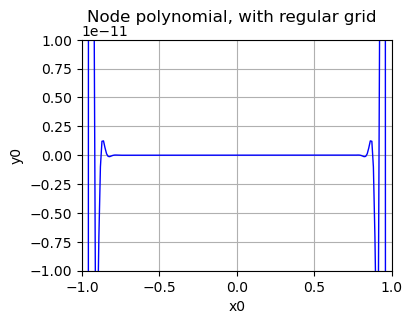

In [28]:
node_polynomial = ot.Function(NodePolynomial(nodes))
epsilon = 1.0e-2
graph = node_polynomial.draw(-1.0 + epsilon, 1.0 - epsilon, 200)
graph.setTitle("Node polynomial, with regular grid")
y_max = 1.0e-11
graph.setBoundingBox(ot.Interval([-1.0, -y_max], [1.0, y_max]))
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

On observe que l'amplitude du polynôme nodal augmente considérablement sur les bords de l'intervalle $[-1, 1]$.

## Convergence de l'approximation

WRN - Negative y values in log-scale axis


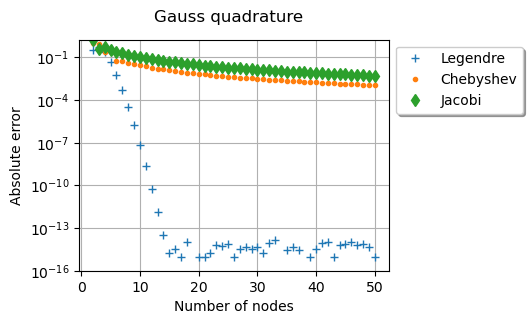

In [29]:
minimumNumberOfNodes = 2
maximumNumberOfNodes = 50
numberOfDifferentNodes = maximumNumberOfNodes - minimumNumberOfNodes + 1
absoluteError = ot.Sample(numberOfDifferentNodes, 4)
exact = 6.586705045354282248777299
columnLegendre = 1
columnChebyshev = 2
columnJacobi = 3
numberOfNodesList = range(minimumNumberOfNodes, 1 + maximumNumberOfNodes)
for i in range(numberOfDifferentNodes):
    numberOfNodes = numberOfNodesList[i]
    absoluteError[i, 0] = numberOfNodes
    # Legendre
    approximateIntegral = gauss_quadrature(numberOfNodes, g, lefa)
    absoluteError[i, columnLegendre] = abs(approximateIntegral - exact)
    # Chebyshev
    approximateIntegral = gauss_quadrature(numberOfNodes, g, chefa)
    absoluteError[i, columnChebyshev] = abs(approximateIntegral - exact)
    # Jacobi
    approximateIntegral = gauss_quadrature(numberOfNodes, g, jafa)
    absoluteError[i, columnJacobi] = abs(approximateIntegral - exact)

graph = ot.Graph("Gauss quadrature", "Number of nodes", "Absolute error", True)
cloud = ot.Cloud(absoluteError[:, 0], absoluteError[:, columnLegendre])
cloud.setLegend("Legendre")
graph.add(cloud)
cloud = ot.Cloud(absoluteError[:, 0], absoluteError[:, columnChebyshev])
cloud.setLegend("Chebyshev")
cloud.setPointStyle("bullet")
graph.add(cloud)
cloud = ot.Cloud(absoluteError[:, 0], absoluteError[:, columnJacobi])
cloud.setLegend("Jacobi")
cloud.setPointStyle("diamond")
graph.add(cloud)
graph.setLogScale(ot.GraphImplementation.LOGY)
graph.setLegendPosition("topright")
graph.setColors(ot.Drawable().BuildDefaultPalette(3))
view = otv.View(
    graph,
    figure_kw={"figsize": (4.0, 3.0)},
    legend_kw={"bbox_to_anchor": (1.0, 1.0), "loc": "upper left"},
)
_ = plt.ylim(bottom=1.0e-16)